In [1]:
#installing Kaggle to directly import dataset into kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kummarapreetham","key":"14fc9afdf15b1380617f853aae8b3030"}'}

In [3]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Downloading dataset from kaggle

In [4]:
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:25<00:00, 39.4MB/s]
100% 612M/612M [00:25<00:00, 24.8MB/s]


In [5]:
!unzip /content/gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

Importing required libraries

In [6]:
import os
import numpy as np
import requests
import zipfile
import torch
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable

import torchvision
import pathlib

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
from pathlib import Path
data_path=Path("/content/")
image_path = data_path

In [8]:
def walk_through_dir(dir_path):
  
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(image_path)

There are 8 directories and 5 images in '/content'.
There are 2 directories and 6 images in '/content/.config'.
There are 0 directories and 1 images in '/content/.config/configurations'.
There are 1 directories and 0 images in '/content/.config/logs'.
There are 0 directories and 6 images in '/content/.config/logs/2023.02.13'.
There are 0 directories and 45 images in '/content/Meta'.
There are 0 directories and 45 images in '/content/meta'.
There are 43 directories and 0 images in '/content/train'.
There are 0 directories and 270 images in '/content/train/24'.
There are 0 directories and 240 images in '/content/train/42'.
There are 0 directories and 360 images in '/content/train/20'.
There are 0 directories and 420 images in '/content/train/6'.
There are 0 directories and 270 images in '/content/train/29'.
There are 0 directories and 240 images in '/content/train/32'.
There are 0 directories and 210 images in '/content/train/0'.
There are 0 directories and 420 images in '/content/train/

In [10]:
train_dir = image_path / "Train"
train_dir

PosixPath('/content/Train')

Random image path: /content/train/4/00004_00035_00016.png
Image class: 4
Image height: 43
Image width: 43


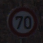

In [11]:
import random
from PIL import Image
random.seed(2) 
image_path_list = list(image_path.glob("*/*/*.png"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Importing libraries

In [12]:
import torch
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import datasets, transforms
from torchvision import models
from torchvision.datasets import ImageFolder

Transforming data into Tensor

In [13]:
transform_data = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
train_dir = image_path / "Train"
 
train_ds = ImageFolder(train_dir,transform=transform_data)

In [15]:
LEN_TRAIN = len(train_ds)

print(LEN_TRAIN)
#index mapping
print(train_ds.class_to_idx)

39209
{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}


In [16]:
from torch.utils.data import random_split

Splitting data into train dataset and test dataset

In [17]:
train_dataset, test_dataset = random_split(train_ds, [32458, 6751])

print("The length of train data is:",len(train_dataset))

print("The length of test data is:",len(test_dataset))

The length of train data is: 32458
The length of test data is: 6751


Data loader

In [18]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = False)

Assign Labels to class_names

In [19]:
class_names = train_ds.classes
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [20]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.3644, -1.3473, -1.2959,  ..., -0.9534, -1.0733, -1.1075],
         [-1.3644, -1.3473, -1.2959,  ..., -0.9705, -1.0904, -1.1075],
         [-1.3644, -1.3473, -1.2959,  ..., -1.1247, -1.1589, -1.1589],
         ...,
         [-1.7412, -1.7412, -1.7583,  ..., -1.8782, -1.8439, -1.8439],
         [-1.7240, -1.7240, -1.7583,  ..., -1.9124, -1.8782, -1.8782],
         [-1.7240, -1.7240, -1.7583,  ..., -1.9124, -1.8782, -1.8782]],

        [[-1.0728, -1.0728, -1.0903,  ..., -0.7227, -0.9328, -0.9853],
         [-1.0728, -1.0728, -1.0903,  ..., -0.7402, -0.9328, -0.9853],
         [-1.0028, -1.0028, -1.0378,  ..., -0.8803, -0.9678, -1.0028],
         ...,
         [-1.6506, -1.6506, -1.6856,  ..., -1.7556, -1.7031, -1.6856],
         [-1.6506, -1.6506, -1.6856,  ..., -1.7731, -1.7206, -1.7031],
         [-1.6506, -1.6506, -1.6856,  ..., -1.7731, -1.7206, -1.7031]],

        [[-0.6715, -0.6541, -0.5670,  ..., -0.2532, -0.5670, -0.6541],
         [-0.6541, -0.6367, -0.

Importing pre trained model - Resnet18

In [21]:
from torchvision.models import resnet18
model = resnet18(pretrained=False)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
model.fc=nn.Linear(512,43)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define Training the data function

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        
        optimizer.zero_grad()

        
        loss.backward()

        
        optimizer.step()

        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

     
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Define Testing data function

In [24]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    
    model.eval() 
    
    
    test_loss, test_acc = 0, 0
    
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
    
            
            test_pred_logits = model(X)

           
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
     
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [25]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    
    return results

In [26]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


from timeit import default_timer as timer 
start_time = timer()

 
model_0_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5286 | train_acc: 0.5460 | test_loss: 0.2690 | test_acc: 0.9150
Epoch: 2 | train_loss: 0.0856 | train_acc: 0.9773 | test_loss: 0.0758 | test_acc: 0.9778
Epoch: 3 | train_loss: 0.0398 | train_acc: 0.9884 | test_loss: 0.0415 | test_acc: 0.9871
Epoch: 4 | train_loss: 0.0283 | train_acc: 0.9923 | test_loss: 0.0258 | test_acc: 0.9935
Epoch: 5 | train_loss: 0.0256 | train_acc: 0.9928 | test_loss: 0.0410 | test_acc: 0.9873
Epoch: 6 | train_loss: 0.0225 | train_acc: 0.9937 | test_loss: 0.0181 | test_acc: 0.9953
Epoch: 7 | train_loss: 0.0146 | train_acc: 0.9959 | test_loss: 0.0454 | test_acc: 0.9858
Epoch: 8 | train_loss: 0.0155 | train_acc: 0.9957 | test_loss: 0.0421 | test_acc: 0.9871
Epoch: 9 | train_loss: 0.0143 | train_acc: 0.9961 | test_loss: 0.0195 | test_acc: 0.9947
Epoch: 10 | train_loss: 0.0127 | train_acc: 0.9964 | test_loss: 0.0051 | test_acc: 0.9985
Epoch: 11 | train_loss: 0.0079 | train_acc: 0.9979 | test_loss: 0.0074 | test_acc: 0.9984
Epoch: 12 | train_l

Vision Transformer

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

from torchvision.models import vit_b_32

In [31]:
model_vit = vit_b_32(pretrained = True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


  0%|          | 0.00/337M [00:00<?, ?B/s]

In [32]:
model_vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [34]:
model_vit.heads = nn.Sequential(
      nn.LayerNorm(768),
      nn.Linear(768,len(class_names)))

In [35]:
model_vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [38]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from torchinfo import summary
summary(model_vit, input_size = [1,3,224,224],col_names = ("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
VisionTransformer                             [1, 3, 224, 224]          [1, 43]                   768
├─Conv2d: 1-1                                 [1, 3, 224, 224]          [1, 768, 7, 7]            2,360,064
├─Encoder: 1-2                                [1, 50, 768]              [1, 50, 768]              38,400
│    └─Dropout: 2-1                           [1, 50, 768]              [1, 50, 768]              --
│    └─Sequential: 2-2                        [1, 50, 768]              [1, 50, 768]              --
│    │    └─EncoderBlock: 3-1                 [1, 50, 768]              [1, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 50, 768]              [1, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 50, 768]              [1, 50, 768]              7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 50,

In [41]:
torch.manual_seed(21) 
torch.cuda.manual_seed(21)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vit.parameters(), lr=0.005, momentum=0.9)

from timeit import default_timer as timer 
start_time = timer()

model_results = train(model=model_vit, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=5)
                       

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7265 | train_acc: 0.7972 | test_loss: 0.0438 | test_acc: 0.9865
Epoch: 2 | train_loss: 0.0524 | train_acc: 0.9848 | test_loss: 0.0780 | test_acc: 0.9763
Epoch: 3 | train_loss: 0.0140 | train_acc: 0.9962 | test_loss: 0.0254 | test_acc: 0.9932
Epoch: 4 | train_loss: 0.0047 | train_acc: 0.9988 | test_loss: 0.0126 | test_acc: 0.9960
Epoch: 5 | train_loss: 0.0023 | train_acc: 0.9994 | test_loss: 0.0098 | test_acc: 0.9973
Total training time: 1898.181 seconds


Attention maps

In [42]:
import cv2
import numpy as np

In [43]:
transform_vit = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


In [44]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

torch.Size([3, 224, 224])


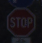

In [45]:
img_path = Path("test/00726.png")

input_img_vit = Image.open(img_path)

input_tensor_vit = transform(input_img_vit).to(device)

print(input_tensor_vit.shape)
input_img_vit

In [46]:
# Function to get output tensor after any particular layer

#att_mat = torch.stack(att_mat).squeeze(1)

attention_mat = {}
def get_activation(name):
  def hook(model,input, output):
    attention_mat[name] = output.detach()
  return hook

In [47]:
# Getting tensor at output of last encoder layer

model_vit.encoder.layers.encoder_layer_11.register_forward_hook(get_activation('Encoder'))
output = model_vit(input_tensor_vit.unsqueeze(0))
att_mat = attention_mat['Encoder']
print(attention_mat['Encoder'].shape)

torch.Size([1, 50, 768])


In [48]:
att_mat = torch.squeeze(att_mat,1)
att_mat = torch.mean(att_mat, dim=1)

In [49]:
att_mat.shape

torch.Size([1, 768])

In [50]:
logits = model_vit(input_tensor_vit.unsqueeze(0))

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(0)).to(device)
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 39:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), input_img_vit.size)[..., np.newaxis]
result = (mask * input_img_vit).astype("uint8")

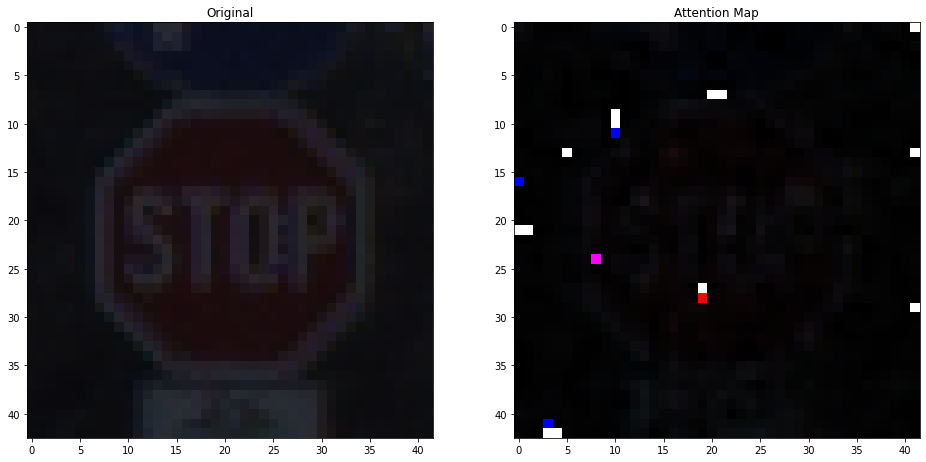

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(input_img_vit)
_ = ax2.imshow(result)

In [52]:
probs = torch.nn.Softmax(dim=-1)(logits)
print(f"Image belongs to class {probs.argmax()}")

Image belongs to class 6


GRAD CAM

In [53]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=51ebb05bc4239f9da9e7c754a88b875412784f310420b1ca78af8ae882a6d352
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [54]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [56]:
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [57]:
transform_gc = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [58]:
target_layers = [model.layer4[-1]]

img_path = Path("test/00841.png")

input_img = Image.open(img_path)

input_tensor = transform_gc(input_img)
#change 3d tensor to 4d tensor
input_tensor_cam = input_tensor[None,:,:,:]

print(input_tensor_cam.shape)
input_img

torch.Size([1, 3, 224, 224])


In [59]:
# gradCam model for a specific layer but can use any image
cam = GradCAM(model = model, target_layers = target_layers, use_cuda=True)


targets = [ClassifierOutputTarget(1)]


grayscale_cam = cam(input_tensor=input_tensor_cam, targets=targets)


grayscale_cam = grayscale_cam[0, :]

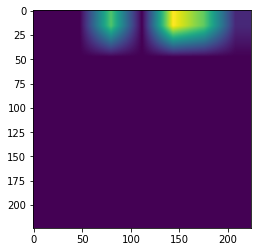

In [60]:
import matplotlib.pyplot as plt

plt.imshow(grayscale_cam)

#show_img2(img_resized, grayscale, alpha=0.8)